In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [3]:
from tensorflow.keras.models import Model

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import cv2

In [7]:
import os

In [8]:
tf.__version__

'2.6.0'

In [9]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    model = tf.keras.Model(inputs=input_layer, outputs= output_layer)
    
    return model

In [10]:
data_size_y = 288

In [11]:
data_size_x = 512

In [12]:
data_path = r"D:\ML Datasets\RGB-D\Monocular\train\LR"

location_path = os.listdir(data_path)

In [13]:
inp_loc = [os.path.join(data_path, folder, 'color') for folder in location_path]
out_loc = [os.path.join(data_path, folder, 'depth_vi') for folder in location_path]

In [14]:
images = np.concatenate([[os.path.join(inp_folder, file) for file in os.listdir(inp_folder)] for inp_folder in inp_loc])

In [15]:
results = np.concatenate([[os.path.join(out_folder, file) for file in os.listdir(out_folder)] for out_folder in out_loc])

In [16]:
images[0]

'D:\\ML Datasets\\RGB-D\\Monocular\\train\\LR\\01. Warehouse\\color\\in_00_160225_144308_c.png'

In [17]:
results[0]

'D:\\ML Datasets\\RGB-D\\Monocular\\train\\LR\\01. Warehouse\\depth_vi\\in_00_160225_144308_depth_vi.png'

In [18]:
input_layer = Input((data_size_y, data_size_x, 1))
model = build_model(input_layer, 16)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 288, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 288, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 144, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
dataset_size = 512

x_test = np.empty((dataset_size, data_size_y, data_size_x, 1))
y_test = np.empty((dataset_size, data_size_y, data_size_x, 1))

In [22]:

for i in range(dataset_size):
    x_test[i] = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE).reshape(data_size_y, data_size_x, 1)
    y_test[i] = cv2.imread(results[i], cv2.IMREAD_GRAYSCALE).reshape(data_size_y, data_size_x, 1)


x_test = x_test / 255
y_test = y_test / 255

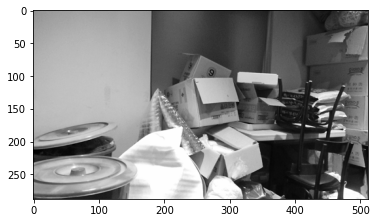

In [23]:
plt.imshow(x_test[0], cmap='gray')

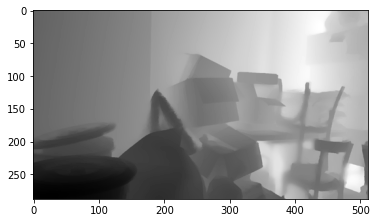

In [24]:
plt.imshow(y_test[0], cmap='gray')

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10419162096249777482
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1740505088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13593381133176380483
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [26]:
tf.config.experimental.get_memory_info('GPU:0')

{'current': 8644096, 'peak': 9440512}

In [27]:
import sys

In [28]:
sys.getsizeof(x_test)

603979920

In [29]:
model.fit(x_test, y_test, batch_size=4, epochs=16, validation_split=0.05)

Epoch 1/16
122/122 [==============================] - 18s 107ms/step - loss: 0.6918 - accuracy: 3.5330e-04 - val_loss: 0.6898 - val_accuracy: 3.5943e-04
Epoch 2/16
122/122 [==============================] - 11s 94ms/step - loss: 0.6900 - accuracy: 3.7398e-04 - val_loss: 0.6858 - val_accuracy: 3.6334e-04
Epoch 3/16
122/122 [==============================] - 11s 94ms/step - loss: 0.6910 - accuracy: 3.6783e-04 - val_loss: 0.6858 - val_accuracy: 3.6178e-04
Epoch 4/16
122/122 [==============================] - 11s 94ms/step - loss: 0.6880 - accuracy: 3.8017e-04 - val_loss: 0.6828 - val_accuracy: 4.1029e-04
Epoch 5/16
122/122 [==============================] - 12s 95ms/step - loss: 0.6826 - accuracy: 4.2048e-04 - val_loss: 0.6784 - val_accuracy: 4.1238e-04
Epoch 6/16
122/122 [==============================] - 12s 96ms/step - loss: 0.6781 - accuracy: 4.2829e-04 - val_loss: 0.6744 - val_accuracy: 4.3716e-04
Epoch 7/16
122/122 [==============================] - 12s 95ms/step - loss: 0.6725 - ac

In [30]:
image = cv2.imread(images[100], cv2.IMREAD_GRAYSCALE)

image = image / 255

truth = cv2.imread(results[100], cv2.IMREAD_GRAYSCALE)

truth = truth / 255

guess = model.predict(image.reshape(-1,data_size_y, data_size_x,1))

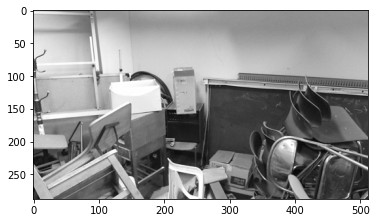

In [31]:
plt.imshow(image, cmap='gray')

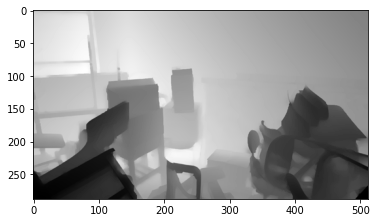

In [32]:
plt.imshow(truth, cmap='gray')

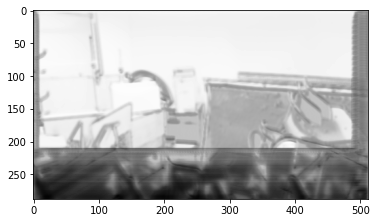

In [33]:
plt.imshow(guess.reshape(data_size_y, data_size_x), cmap='gray')

In [189]:
print(np.max(guess))

0.509879
